#  import libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,BatchNormalization,MaxPooling2D,Conv2D,Input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import Model
from sklearn.metrics import classification_report , confusion_matrix

# get images from dataset files

In [3]:
train_normal = glob.glob('/kaggle/input/pneumonia-chest-x-ray-dataset/train/normal/*.jpeg')
train_pneumonia = glob.glob('/kaggle/input/pneumonia-chest-x-ray-dataset/train/pneumonia/*.jpeg')

test_normal = glob.glob('/kaggle/input/pneumonia-chest-x-ray-dataset/test/normal/*.jpeg')
test_pneumonia = glob.glob('/kaggle/input/pneumonia-chest-x-ray-dataset/test/pneumonia/*.jpeg')

val_normal = glob.glob('/kaggle/input/pneumonia-chest-x-ray-dataset/val/normal/*.jpeg')
val_pneumonia = glob.glob('/kaggle/input/pneumonia-chest-x-ray-dataset/val/pneumonia/*.jpeg')

normal = train_normal + test_normal + val_normal
pneumonia = train_pneumonia + test_pneumonia + val_pneumonia

random.shuffle(normal)
random.shuffle(pneumonia)

train_normal = normal [:int (len (normal) *0.8)]
test_normal = normal[int (len (normal) *0.8):]

train_pneumonia = pneumonia [:int (len (pneumonia) *0.8)]
test_pneumonia = pneumonia[int (len (pneumonia) *0.8):]

print ('number of train normal x-rays = {}'.format(len (train_normal)))
print ('number of train pneumonia x-rays = {}'.format(len (train_pneumonia)))

print ('------------------------------------')

print ('number of test normal x-rays = {}'.format(len (test_normal)))
print ('number of test pneumonia x-rays = {}'.format(len (test_pneumonia)))

number of train normal x-rays = 1266
number of train pneumonia x-rays = 3418
------------------------------------
number of test normal x-rays = 317
number of test pneumonia x-rays = 855


# plot sample of each catogery 

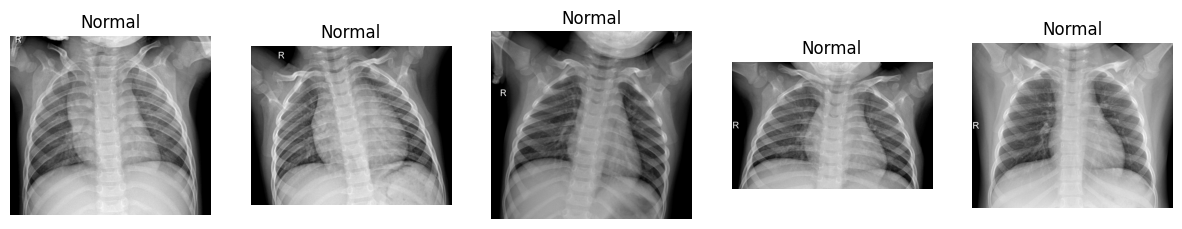

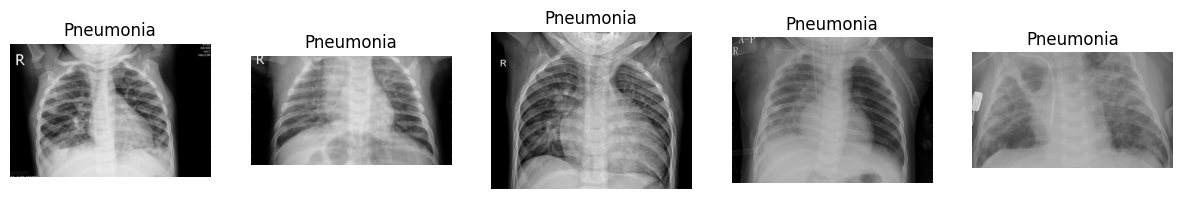

In [4]:
def plot_images (data ,image_title,num_of_images ,type_image = 'bgr'):
    plt.figure(figsize=(15,10))
    for i in range (num_of_images):
        random_image = random.choice(data)
        if type (data) == list:
            random_image = cv2.imread(random_image)
            
        if type_image.lower() == 'bgr':
            random_image =  cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
            
        plt.subplot(1,num_of_images,i+1)
        plt.imshow(random_image)
        plt.axis('off')
        plt.title (image_title)
    
    plt.show()

plot_images (train_normal ,'Normal',5)
plot_images (train_pneumonia ,'Pneumonia',5)

# plot categories distribution

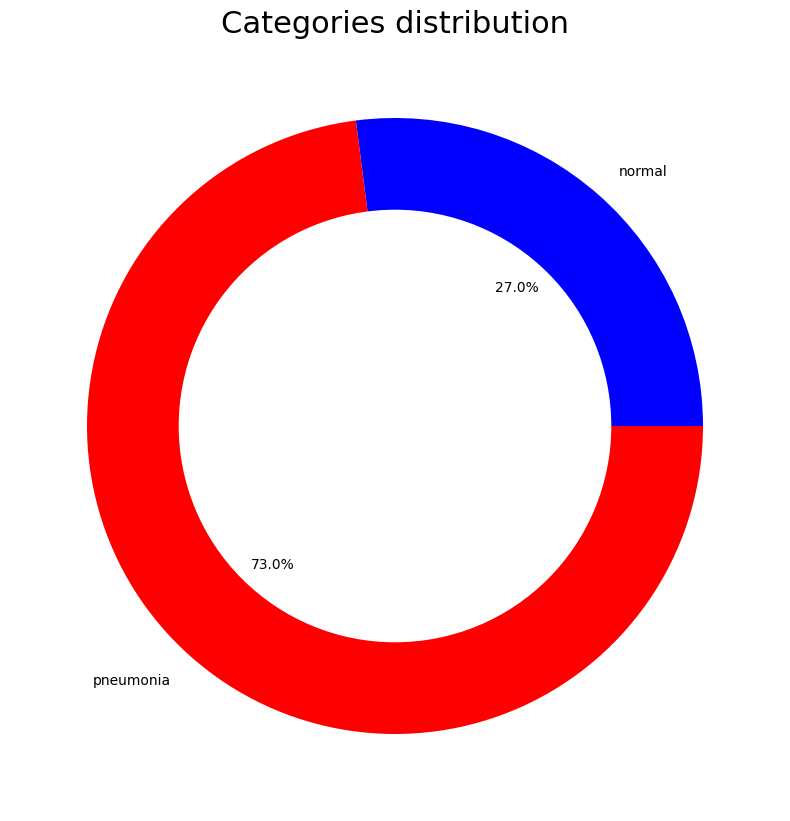

In [5]:
def plt_pie (data,labels,colors,title):
    plt.figure(figsize=(20,10))
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(data,labels = labels, colors = colors , autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title (title,fontsize = 22)
    plt.show()
    
data = [len (train_normal) , len (train_pneumonia) ]
labels = ['normal' , 'pneumonia' ]
colors = ['blue','red']
plt_pie (data,labels,colors , 'Categories distribution')

# define functions to agumante image

In [6]:
def image_augmentation(low_data,target , p=0.5):
    
    images =[]
    
    albumentation_list = [A.RandomBrightness(limit = 0.5, p=p),A.RGBShift(p=p), A.RandomContrast(limit = 0.5,p =p) ,
                          A.Rotate(p=p, limit=40) , A.RandomCrop(p=p,height = 200, width = 200)]
    
    while (len (images) < target):
        for image in low_data:
            img = cv2.resize(cv2.imread(image), (256, 256) )
            operation = random.choice(albumentation_list)
            img = operation (image = img)['image']
            
            if img.shape[0] !=256:
                img = cv2.resize (img , (256, 256))
    
            images.append (img)
        
            if (len (images) >= target):
                break
    return np.array (images)

In [7]:
def convert_links_to_images(data):
    images =[]
    for image in data:
        img = cv2.resize(cv2.imread(image), (256, 256) )
        images.append(img)
    return np.array (images)

In [8]:
train_normal_images = image_augmentation(train_normal,3500,p=1)
train_pneumonia_images = image_augmentation(train_pneumonia,3500,p=1)

test_normal_images = convert_links_to_images(test_normal)
test_pneumonia_images = convert_links_to_images(test_pneumonia)

# plot distribution of train data after balncing 

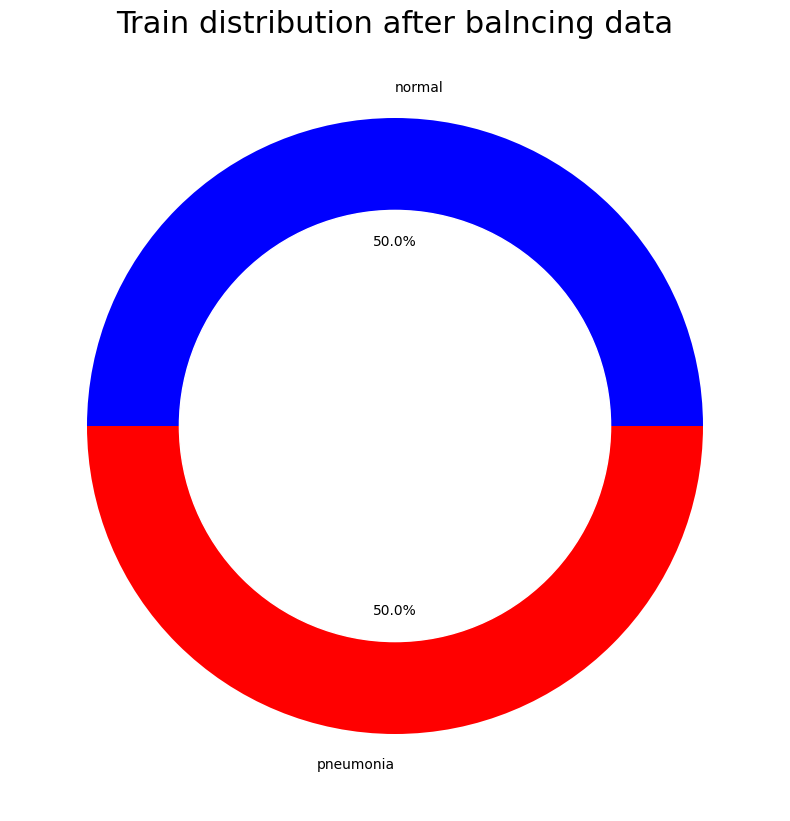

In [9]:
plt_pie ([len (train_normal_images) ,len (train_pneumonia_images)] ,labels,colors,'Train distribution after balncing data')

# plot sample from each category after preprocessing

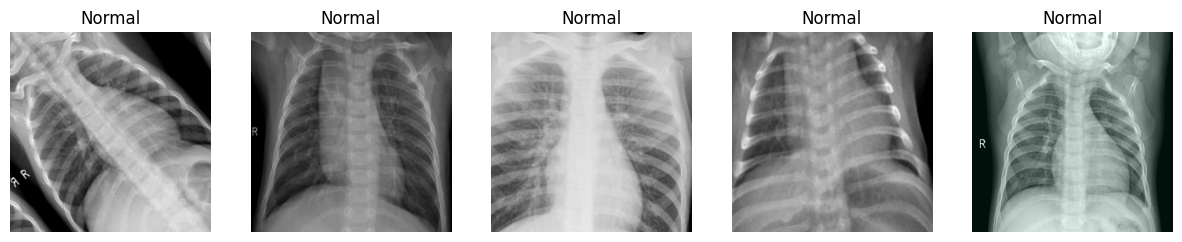

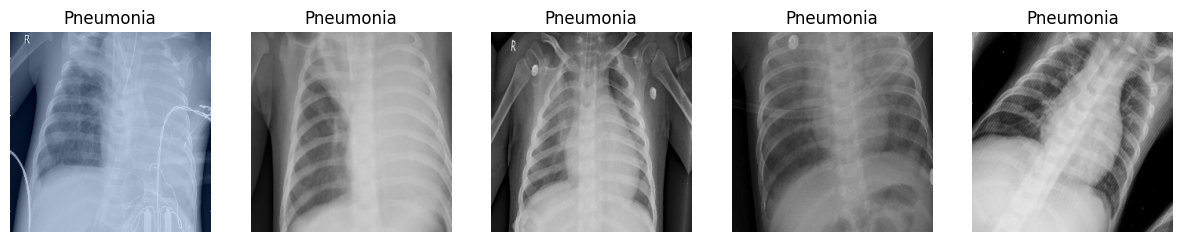

In [10]:
#Train data
plot_images (train_normal_images ,'Normal',5)
plot_images (train_pneumonia_images ,'Pneumonia',5)

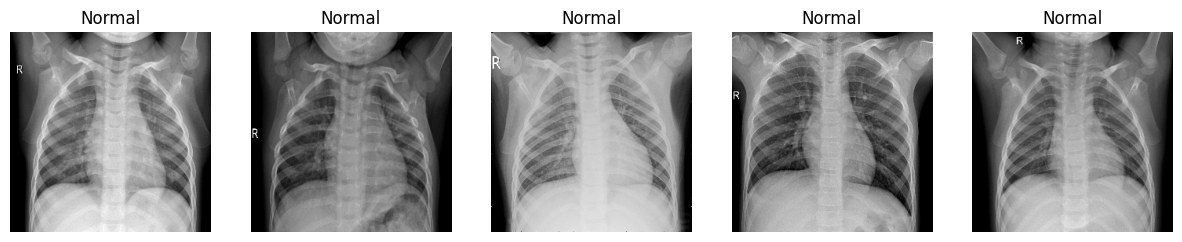

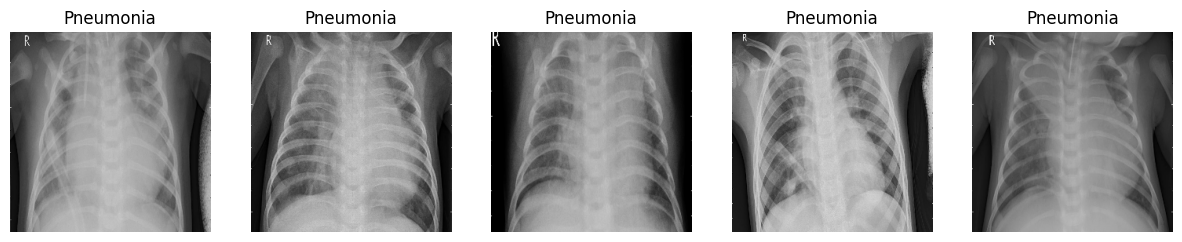

In [11]:
#Test data
plot_images (test_normal_images ,'Normal',5)
plot_images (test_pneumonia_images ,'Pneumonia',5)

# get train and test data

In [12]:
y_train = np.concatenate ([np.zeros (len(train_normal_images)) , np.ones (len (train_pneumonia_images)) ])
X_train = np.concatenate ([train_normal_images,train_pneumonia_images],axis = 0)

y_test = np.concatenate ([np.zeros (len(test_normal_images)) , np.ones (len (test_pneumonia_images))] )
X_test = np.concatenate ([test_normal_images,test_pneumonia_images],axis = 0)

print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)
#--------------------------------free some memory--------------------------------
train_normal_images,train_pneumonia_images,test_normal_images,test_pneumonia_images = None,None,None,None
del train_normal_images,train_pneumonia_images,test_normal_images,test_pneumonia_images 

(7000, 256, 256, 3)
(7000,)
(1172, 256, 256, 3)
(1172,)


In [13]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255,)

train_generator = train_datagen.flow(X_train, y_train,batch_size=16,shuffle=True)
test_generator = test_datagen.flow(X_test, y_test,batch_size=16,shuffle=False)
#--------------------------------free some memory--------------------------------
X_train,y_train,X_test = None, None,None
del X_train,y_train,X_test

# get inception_v3 pre trained model

In [14]:
inception = keras.applications.inception_v3.InceptionV3 (input_shape = (256,256,3),
                                                            include_top = False,
                                                            weights = 'imagenet')
inception.trainable = False   

87910968/87910968 [==============================] - 2s 0us/step


# build full-model and fit model

In [20]:
last_output = inception.get_layer('mixed8').output 
x = Flatten()(last_output)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inception.input, outputs=x)
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True,verbose = 1),
             ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]
            
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,epochs=100,validation_data=test_generator,callbacks=[callbacks])
model.load_weights('model.h5')

Epoch 1/100
438/438 [==============================] - 112s 248ms/step - loss: 0.2818 - accuracy: 0.8824 - val_loss: 0.2786 - val_accuracy: 0.8848
Epoch 2/100
438/438 [==============================] - 108s 247ms/step - loss: 0.2093 - accuracy: 0.9190 - val_loss: 0.1770 - val_accuracy: 0.9377
Epoch 3/100
438/438 [==============================] - 105s 240ms/step - loss: 0.1898 - accuracy: 0.9257 - val_loss: 0.2951 - val_accuracy: 0.8831
Epoch 4/100
438/438 [==============================] - 106s 242ms/step - loss: 0.1745 - accuracy: 0.9319 - val_loss: 0.2354 - val_accuracy: 0.9130
Epoch 5/100
438/438 [==============================] - 108s 247ms/step - loss: 0.1687 - accuracy: 0.9331 - val_loss: 0.1639 - val_accuracy: 0.9454
Epoch 6/100
438/438 [==============================] - 106s 242ms/step - loss: 0.1594 - accuracy: 0.9397 - val_loss: 0.1818 - val_accuracy: 0.9300
Epoch 7/100
438/438 [==============================] - 108s 246ms/step - loss: 0.1680 - accuracy: 0.9353 - val_loss: 0

# plot loss and accuracy

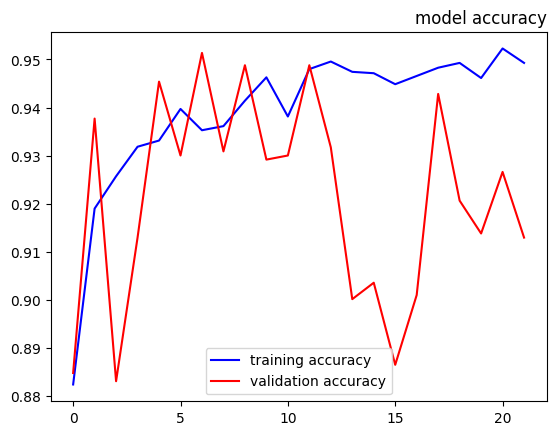

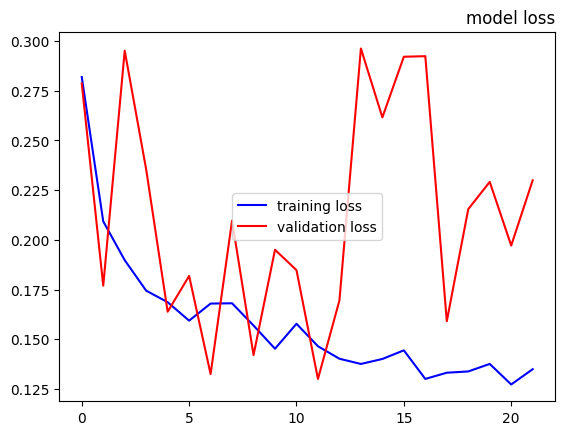

In [21]:
train_loss = history.history['loss']
val_loss = history.history['val_loss'] 
tarin_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range (len (tarin_acc)),tarin_acc,c='b',label = 'training accuracy')
plt.plot (range (len (val_acc)),val_acc,c='r',label = 'validation accuracy')
plt.title ('model accuracy',loc ='right')
plt.legend()
plt.show()

plt.plot(range (len (train_loss)),train_loss,c='b',label = 'training loss')
plt.plot (range (len (val_loss)),val_loss,c='r',label = 'validation loss')
plt.title ('model loss',loc ='right')
plt.legend()
plt.show()

# get predicted output

In [22]:
y_pred = model.predict (test_generator)
y_pred = y_pred.reshape (-1,)
y_pred = np.float16(y_pred>=0.5 )

74/74 [==============================] - 4s 42ms/step


# print confusion matrix and classification report


              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91       317
         1.0       0.97      0.96      0.96       855

    accuracy                           0.95      1172
   macro avg       0.93      0.94      0.94      1172
weighted avg       0.95      0.95      0.95      1172



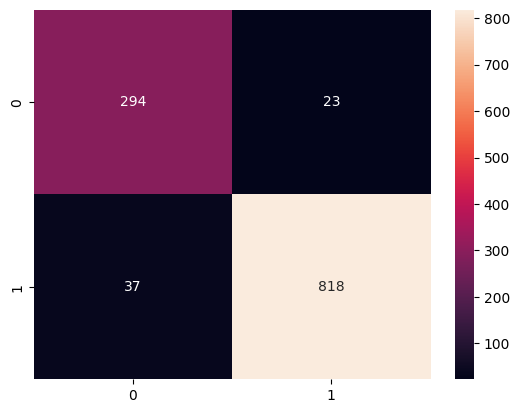

In [23]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True,fmt='d')
print (classification_report (y_test,y_pred))